In [1]:
from hnefatal.game import *

import torch
from torch import nn

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

BOARD_WIDTH = 13
DISTANCE_SIZE = BOARD_WIDTH - 1
LABEL_SIZE = 4056 # Equal to valid_mask.sum()

# Precompute all possible moves and their probabilities in a single pass
from_rows, from_cols = torch.meshgrid(torch.arange(BOARD_WIDTH), torch.arange(BOARD_WIDTH), indexing='ij')
directions = torch.arange(4)
distances = torch.arange(1, DISTANCE_SIZE + 1)

# Expand to all combinations
from_rows = from_rows.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 4, DISTANCE_SIZE)
from_cols = from_cols.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 4, DISTANCE_SIZE)
directions = directions.view(1, 1, 4, 1).expand(BOARD_WIDTH, BOARD_WIDTH, 4, DISTANCE_SIZE)
distances = distances.view(1, 1, 1, DISTANCE_SIZE).expand(BOARD_WIDTH, BOARD_WIDTH, 4, DISTANCE_SIZE)

# Calculate destination coordinates
to_rows = from_rows + torch.where(directions == 0, -distances, torch.where(directions == 1, distances, torch.zeros_like(distances)))
to_cols = from_cols + torch.where(directions == 2, -distances, torch.where(directions == 3, distances, torch.zeros_like(distances)))

# Mask for valid board positions
valid_mask = (
    (from_rows >= 0) & (from_rows < BOARD_WIDTH) &
    (from_cols >= 0) & (from_cols < BOARD_WIDTH) &
    (to_rows >= 0) & (to_rows < BOARD_WIDTH) &
    (to_cols >= 0) & (to_cols < BOARD_WIDTH)
)

assert valid_mask.sum() == LABEL_SIZE, f"Expected {LABEL_SIZE} valid moves, but got {valid_mask.sum()}"

# TODO: Remove positions moving from corner 
label_index_by_move = [Move(Coord(0, 0), Coord(0, 0))] * LABEL_SIZE

def apply_direction(row, col, direction, distance):
    assert distance > 0
    
    if direction == 0:   # Up
        return row - distance, col
    elif direction == 1: # Down
        return row + distance, col
    elif direction == 2: # Left
        return row, col - distance
    elif direction == 3: # Right
        return row, col + distance

i = 0
for from_row in range(BOARD_WIDTH):
    for from_col in range(BOARD_WIDTH):
        for direction in range(4):
            for distance in range(1, DISTANCE_SIZE + 1):
                to_row, to_col = apply_direction(from_row, from_col, direction, distance)

                from_pos = Coord(from_row, from_col)
                to_pos = Coord(to_row, to_col)

                if valid_mask[from_row, from_col, direction, distance - 1]:
                    label_index_by_move[i] = Move(from_pos, to_pos)
                    i += 1
                    

def encode_move_to_index(move: Move):
    row, col, = move.from_pos.x, move.from_pos.y
    diff = move.to_pos - move.from_pos
    movement = diff.x if diff.x != 0 else diff.y
    direction = movement / abs(movement)
    distance = abs(movement)

    assert distance != 0

    return int(row * BOARD_WIDTH * 4 * DISTANCE_SIZE + col * 4 * DISTANCE_SIZE + direction * DISTANCE_SIZE + distance)


class SimpleDefendersModel(nn.Module):
    def __init__(self):
        super(SimpleDefendersModel, self).__init__()
        self.encode = nn.functional.one_hot
        self.nn = nn.Sequential(
            nn.Linear(BOARD_WIDTH*BOARD_WIDTH*4, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, LABEL_SIZE),
            nn.Softmax (dim=-1)  # Softmax to get probabilities for each move
        )

    def forward(self, x):
        x = self.encode(x, num_classes=4)
        x = x.type(torch.float32).flatten().reshape(1,-1)
        logits = self.nn(x)
        return logits
    
model = SimpleDefendersModel().to(device)

Using cpu device


Initially, each model hits about 80 invalid moves before the move with highest probability is found.


In [ ]:
def find_ai_move_sort(game: Game, player):

    # Flatten the board and get the value of each piece
    x = torch.tensor(game.board).reshape(-1, 1)

    # Model prediction
    logits = model(x).flatten()
    indices = logits.argsort()

    for idx in indices:
        # Recover indices
        move = label_index_by_move[idx.item()]

        # Initially, on average the first 80 moves a invalid
        if game.piece_at(move.from_pos).get_player() == Player.DEFENDER and game.is_valid_move(move.from_pos, move.to_pos):
            return move, logits
        
    raise IndexError("No valid moves for AI")

def find_ai_move_clone(game: Game, player):

    # Flatten the board and get the value of each piece
    x = torch.tensor(game.board).reshape(-1, 1)

    # Model prediction
    model_prediction = model(x)
    logits = model_prediction.detach().clone().flatten()
    # The tensor is cloned because the backpropagation takes wayyy to long, when it has to consider all the probabilities being set to zero

    while True:
        idx = logits.argmax().item()
        assert logits[idx] != 0, "No valid moves found"

        # Recover indices
        move = label_index_by_move[idx]

        # Initially, on average the first 80 moves a invalid
        if game.piece_at(move.from_pos).get_player() == Player.DEFENDER and game.is_valid_move(move.from_pos, move.to_pos):
                
            return move, model_prediction
        else:
            # Set the probability of this move to zero and continue
            logits[idx] = 0 
            
            continue


def find_ai_move_topn(game: Game, player):

    # Flatten the board and get the value of each piece
    x = torch.tensor(game.board).reshape(-1, 1)

    # Model prediction
    model_prediction = model(x)
    logits = model_prediction.detach().clone().flatten()
    # The tensor is cloned because the backpropagation takes wayyy to long, when it has to consider all the probabilities being set to zero

    while True:
        top_indices = logits.topk(80).indices
        for idx in top_indices:
            idx = idx.item()

            # Recover indices
            move = label_index_by_move[idx]

            # Initially, on average the first 80 moves a invalid
            if game.piece_at(move.from_pos).get_player() == Player.DEFENDER and game.is_valid_move(move.from_pos, move.to_pos):
                    
                return move, model_prediction
            else:
                continue

        logits[top_indices] = 0

from time import perf_counter
def test_func(func):
    start = perf_counter()
    for _ in range(1000):
        func()
    return perf_counter() - start

from hnefatal.game import Game, Player
game = Game()
game.fill_board_13_by_13()
argmax = test_func(lambda: find_ai_move_clone(game, Player.DEFENDER))
sort = test_func(lambda: find_ai_move_sort(game, Player.DEFENDER))
topn = test_func(lambda: find_ai_move_topn(game, Player.DEFENDER))

print(f"Argmax: {argmax}\nSort: {sort}\nTopN: {topn}")

Argmax: 1.7560768000003009
Sort: 7.13531409999996
TopN: 1.58263960000113


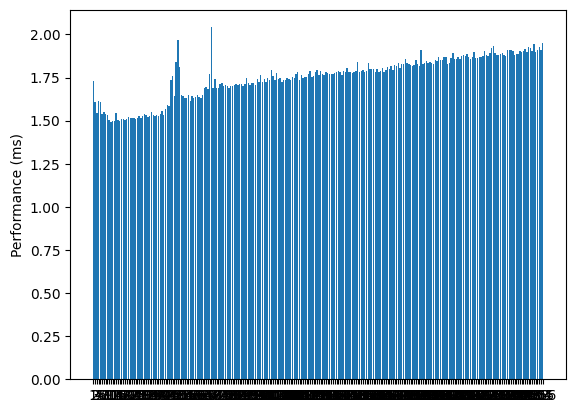

In [25]:
def find_ai_move_topn(game: Game, size):

    # Flatten the board and get the value of each piece
    x = torch.tensor(game.board).reshape(-1, 1)

    # Model prediction
    model_prediction = model(x)
    logits = model_prediction.detach().clone().flatten()
    # The tensor is cloned because the backpropagation takes wayyy to long, when it has to consider all the probabilities being set to zero

    while True:
        top_indices = logits.topk(size).indices
        for idx in top_indices:
            idx = idx.item()

            # Recover indices
            move = label_index_by_move[idx]

            # Initially, on average the first 80 moves a invalid
            if game.piece_at(move.from_pos).get_player() == Player.DEFENDER and game.is_valid_move(move.from_pos, move.to_pos):
                    
                return move, model_prediction
            else:
                continue

        logits[top_indices] = 0

from time import perf_counter
def test_func(func):
    start = perf_counter()
    for _ in range(1000):
        func()
    return perf_counter() - start

game = Game()
game.fill_board_13_by_13()

MAX = 256
tests = [None] * MAX
for i in range(0, MAX):
    perf = test_func(lambda: find_ai_move_topn(game, i + 1))
    tests[i] = perf

import matplotlib.pyplot as plt
import numpy as np

plt.bar(range(MAX), tests, tick_label=np.arange(MAX)+1)
# plt.axes((0, 0, MAX + 2, 15))
plt.ylabel('Performance (ms)')
# plt.yticks(labels="ms", ticks=None)
plt.show()